In [31]:
import os 
import cv2 
import numpy as np
from tqdm import tqdm 

rebuild_data = False # So we don't have to rebuild the dataset after every run through. Switch to false after one time of running

# You can have any amount of dimensions for a CNN.
class CatsvsDogs():
    img_size = 50 # Sets the images to 50x50
    cats = r"C:\Users\UDESP\Downloads\kagglecatsanddogs_5340\PetImages\Cat" # File diectory for cats
    dogs = r"C:\Users\UDESP\Downloads\kagglecatsanddogs_5340\PetImages\Dog" # File directory for dogs
    labels = {cats: 0, dogs: 1} # Sets 0 for cats and 1 for dogs

    training_data = [] # Enpty set for now
    cat_count = 0 # Counter for cats for balance purposes
    dog_count = 0 # Counter for dogs for balance purposes

    def creating_training_data(self): 
        for label in self.labels: # Iterates through cats and dogs directory
            print(label)
            for f in tqdm(os.listdir(label)): # Iterates through the images in the directory 
                try: # Used to indicate to us if there is a bad image in the datasets
                    path = os.path.join(label, f) # Concatonates the directory name label with the filename f
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Converts images to grey scale. Makes the NN smaller which is good
                    img = cv2.resize(img, (self.img_size, self.img_size)) # Resizes the images to 50x50
                    self.training_data.append([np.array(img), np.eye(2)[self.labels[label]]]) # np.eye is used for one hot vector creation. Appends all the information to our training data

                    if label == self.cats: # Adds one to either cats or dogs depending on what image is shown. 
                        self.cat_count += 1
                    elif label == self.dogs:
                        self.dog_count += 1
                except Exception as e:
                    pass # Passes over the images that can't be reshaped to the 50x50 parameter we wanted

        np.random.shuffle(self.training_data) # Shuffels the data in place
        self.training_data = np.array(self.training_data, dtype=object) # Specifies that the elements should be treated as an object rather than pixels. 
        np.save("training_data.npy", self.training_data) # Saves data to a binary file 
        print("Cats", self.cat_count)  
        print("Dogs", self.dog_count)

if rebuild_data:
    dogsvcats = CatsvsDogs() # Creates a new instance of CNN 
    dogsvcats.creating_training_data() # Processes the image files 






C:\Users\UDESP\Downloads\kagglecatsanddogs_5340\PetImages\Cat


100%|██████████| 12501/12501 [00:13<00:00, 938.87it/s]


C:\Users\UDESP\Downloads\kagglecatsanddogs_5340\PetImages\Dog


100%|██████████| 12501/12501 [00:14<00:00, 861.83it/s]


Cats 12476
Dogs 12470


In [32]:
training_data = np.load("training_data.npy", allow_pickle=True) # So we don't have to run the whole algorithm multiple times. Have to set pickle to true as an error message is displayed if not stated.
print(len(training_data))# Prints all training samples

24946


In [28]:
print(training_data[0]) # Prints a cat one hot vector

[array([[207, 210, 214, ..., 255, 253, 248],
        [166, 166, 171, ..., 255, 255, 255],
        [132, 131, 132, ..., 255, 255, 255],
        ...,
        [ 79,  78,  75, ...,  58,  56,  54],
        [ 78,  80,  81, ...,  68,  63,  58],
        [ 75,  75,  75, ...,  66,  60,  62]], dtype=uint8) array([1., 0.])]


In [29]:
print(training_data[1]) # Prints a dog one hot vector

[array([[ 84,  94,  86, ...,  78,  83, 189],
        [ 81,  82,  85, ...,  82,  90,  32],
        [ 73,  72,  75, ...,  77,  84,  85],
        ...,
        [108,  88,  81, ...,  82,  96, 102],
        [ 87,  83,  55, ..., 102,  92,  86],
        [ 87, 105,  83, ...,  94,  85,  39]], dtype=uint8) array([0., 1.])]


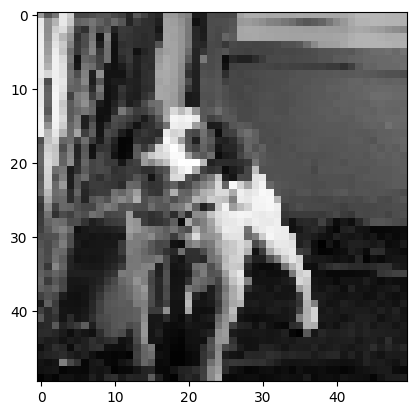

In [24]:
import matplotlib.pyplot as plt

plt.imshow(training_data[2][0], cmap="gray") # Prints either a cat or a dog depending on which index inputed(Where the 2 is)
plt.show()

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # This is the input layer. The 1 is the amount of inputs, the 32 is the output of the convolutional features, and 5 is the kernal size(5x5 kernal/window)
        self.conv2 = nn.Conv2d(32, 64, 5)# Takes the amount of outputs from the previous layer. 64 is the output of the convolutional features. 
        self.conv3 = nn.Conv2d(64, 128, 5)# Takes the amount of outputs from previous layer. 128 is now the output of the convolutional features. 

        # Dummy input to calculate the flat features after convolutional layer
        x = torch.randn(50,50).view(-1, 1, 50, 50) # Creates a tensor of a 50x50. The .view(-1, 1, 50, 50) are parameters suitable for a CNN
        self.to_linear = None 
        self.convs(x)
        self.fc1 = nn.Linear(self.to_linear, 512) # Fully connected layer with 512 dense layers. Have to do a forward pass to find the value of self.to_linear which is a pain. 
        self.fc2 = nn.Linear(512, 2) # Returns two classes: Cats and Dogs

    def convs(self, x): # Adds a series of convolutional and pooling layers to the input tensor x
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        print(x[0].shape)

        if self.to_linear is None: 
            self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] # This calculates the flattened size needed for a parameter  in the fully collected layer 1. 
        return x
        
    def forward(self, x): # Propagates the input x through the CNN
        x = self.convs(x) 
        x = x.view(-1, self.to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

net = CNN()

       



torch.Size([128, 2, 2])


In [55]:
import torch.optim as optim 

optimizer = optim.Adam(net.parameters(), lr=.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50) # Iterates over the input features using a tensor in a list of tuples(are like lists but immutable) or lists
X = X/255.0 # Scaling the imagry 
y = torch.Tensor([i[1] for i in training_data]) # Iterates over the training data for labels or targets asociates with the training set. 

val_pct = 0.1 # Testing against 10 percent of our dataset
val_size = int(len(X)*val_pct) # using as a number to splice data
print(val_size)

2494


In [56]:
train_X = X[:-val_size] # Trains the X part of the dataset
train_y = y[:-val_size] # Trains the y part of the dataset

test_X = X[-val_size:] # Tests the X part of the dataset
test_y = y[-val_size:] # Tests the y part of the dataset

print(len(train_X))
print(len(test_X))


22452
2494


In [57]:
batch_size = 128 # How much data is fed into the neural network at a time
EPOCHS = 1 # Number of completed runs

for epoch in range(EPOCHS): # Iterates through the EPOCHS to see how many full completed times it will run through the NN
    for i in tqdm(range(0, len(train_X), batch_size)): # Creates a process bar so we can see what is going on. 
        # print(i, i+batch_size)
        batch_X = train_X[i:i+batch_size].view(-1, 1, 50, 50) # Selects a subset from train_x to reshape it
        batch_y = train_y[i:i+batch_size] # Selects labels from train_y for the training data

        net.zero_grad() # The saer way. Can also use optimiser.zero_grad
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

print(loss)

  0%|          | 0/176 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  1%|          | 1/176 [00:00<00:35,  4.87it/s]

torch.Size([128, 2, 2])


  1%|          | 2/176 [00:00<00:32,  5.41it/s]

torch.Size([128, 2, 2])


  2%|▏         | 3/176 [00:00<00:31,  5.57it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/176 [00:00<00:29,  5.75it/s]

torch.Size([128, 2, 2])


  3%|▎         | 5/176 [00:00<00:29,  5.85it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/176 [00:01<00:28,  5.87it/s]

torch.Size([128, 2, 2])


  4%|▍         | 7/176 [00:01<00:27,  6.08it/s]

torch.Size([128, 2, 2])


  5%|▌         | 9/176 [00:01<00:29,  5.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▋         | 11/176 [00:01<00:27,  5.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 13/176 [00:02<00:27,  5.87it/s]

torch.Size([128, 2, 2])


  8%|▊         | 14/176 [00:02<00:31,  5.10it/s]

torch.Size([128, 2, 2])


  9%|▊         | 15/176 [00:02<00:31,  5.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|▉         | 17/176 [00:03<00:28,  5.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 19/176 [00:03<00:24,  6.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 21/176 [00:03<00:22,  6.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 23/176 [00:03<00:21,  7.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 25/176 [00:04<00:20,  7.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▌        | 27/176 [00:04<00:20,  7.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▋        | 29/176 [00:04<00:20,  7.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 31/176 [00:04<00:21,  6.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 33/176 [00:05<00:20,  7.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 35/176 [00:05<00:19,  7.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 37/176 [00:05<00:20,  6.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 39/176 [00:06<00:20,  6.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 41/176 [00:06<00:19,  6.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 43/176 [00:06<00:20,  6.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 45/176 [00:06<00:19,  6.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 47/176 [00:07<00:18,  6.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 49/176 [00:07<00:18,  6.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 51/176 [00:07<00:17,  7.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 53/176 [00:08<00:19,  6.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███▏      | 55/176 [00:08<00:18,  6.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 57/176 [00:08<00:17,  6.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▎      | 59/176 [00:09<00:16,  6.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▍      | 61/176 [00:09<00:16,  6.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 63/176 [00:09<00:16,  7.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 65/176 [00:09<00:15,  7.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 67/176 [00:10<00:15,  7.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 69/176 [00:10<00:14,  7.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 71/176 [00:10<00:14,  7.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████▏     | 73/176 [00:10<00:14,  7.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 75/176 [00:11<00:15,  6.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 77/176 [00:11<00:14,  6.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 79/176 [00:11<00:16,  5.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 81/176 [00:12<00:15,  5.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 83/176 [00:12<00:16,  5.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 85/176 [00:12<00:14,  6.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 87/176 [00:13<00:14,  6.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 89/176 [00:13<00:13,  6.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 91/176 [00:13<00:13,  6.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 93/176 [00:14<00:12,  6.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 95/176 [00:14<00:12,  6.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▌    | 97/176 [00:14<00:12,  6.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 99/176 [00:15<00:11,  6.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 101/176 [00:15<00:12,  6.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▊    | 103/176 [00:15<00:12,  5.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 105/176 [00:16<00:11,  6.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 107/176 [00:16<00:10,  6.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 109/176 [00:16<00:09,  6.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 111/176 [00:17<00:10,  6.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 113/176 [00:17<00:09,  6.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 115/176 [00:17<00:08,  6.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▋   | 117/176 [00:17<00:08,  7.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 119/176 [00:18<00:07,  7.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 121/176 [00:18<00:08,  6.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 123/176 [00:18<00:07,  6.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 125/176 [00:19<00:07,  7.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 127/176 [00:19<00:07,  6.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 129/176 [00:19<00:06,  6.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 131/176 [00:19<00:06,  6.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 133/176 [00:20<00:06,  6.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 135/176 [00:20<00:06,  6.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 137/176 [00:20<00:06,  6.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 139/176 [00:21<00:06,  5.94it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 140/176 [00:21<00:06,  5.71it/s]

torch.Size([128, 2, 2])


 80%|████████  | 141/176 [00:21<00:06,  5.05it/s]

torch.Size([128, 2, 2])


 81%|████████  | 142/176 [00:21<00:06,  5.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 144/176 [00:22<00:06,  5.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 146/176 [00:22<00:05,  5.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 148/176 [00:22<00:05,  5.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 150/176 [00:23<00:04,  5.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▋ | 152/176 [00:23<00:04,  5.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 154/176 [00:24<00:03,  5.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▊ | 156/176 [00:24<00:03,  5.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 158/176 [00:24<00:03,  5.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 160/176 [00:25<00:02,  5.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 162/176 [00:25<00:02,  5.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 164/176 [00:25<00:02,  5.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 166/176 [00:26<00:01,  5.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▌| 168/176 [00:26<00:01,  5.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 170/176 [00:26<00:01,  5.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 172/176 [00:27<00:00,  6.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 174/176 [00:27<00:00,  6.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 176/176 [00:27<00:00,  6.33it/s]

torch.Size([128, 2, 2])
tensor(0.2418, grad_fn=<MseLossBackward0>)


In [58]:
correct = 0
total = 0
with torch.no_grad(): # Used to indicate there is no need to compute gradients during this evaluation phase 
    for i in tqdm(range(len(test_X))): # Iterates over the test dataset 
        real_class = torch.argmax(test_y[i]) # Gets true class label for current test sample 
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0] # Used to reshape input shape for the neural network
        # print(real_class, net_out)
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy:", round(correct/total, 3))



  2%|▏         | 57/2494 [00:00<00:08, 293.61it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.5882, 0.4118])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6199, 0.3801])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5087, 0.4913])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5487, 0.4513])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5991, 0.4009])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4131, 0.5869])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5328, 0.4672])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5670, 0.4330])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5472, 0.4528])
torch.Size([128, 2, 2])
tensor(1) tensor([0.7290, 0.2710])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5746, 0.4254])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4926, 0.5074])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4800, 0.5200])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5444, 0.4556])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5686, 0.4314])
torch.Size([128, 2, 2])
tensor(1) tensor([0.7055, 0.2945])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4247, 0.5753

  5%|▌         | 131/2494 [00:00<00:06, 342.51it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.5277, 0.4723])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4976, 0.5024])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4643, 0.5357])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5797, 0.4203])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5040, 0.4960])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5165, 0.4835])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6002, 0.3998])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4054, 0.5946])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5878, 0.4122])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5814, 0.4186])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5518, 0.4482])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5274, 0.4726])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5803, 0.4197])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4587, 0.5413])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4101, 0.5899])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5328, 0.4672])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6171, 0.3829

  8%|▊         | 206/2494 [00:00<00:06, 354.46it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.5532, 0.4468])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4537, 0.5463])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5252, 0.4748])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4365, 0.5635])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5452, 0.4548])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5919, 0.4081])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6335, 0.3665])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5668, 0.4332])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6314, 0.3686])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4894, 0.5106])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5330, 0.4670])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4683, 0.5317])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4617, 0.5383])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5937, 0.4063])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3579, 0.6421])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6614, 0.3386])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3853, 0.6147

 11%|█         | 278/2494 [00:00<00:06, 350.59it/s]

tensor([0.5467, 0.4533])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4008, 0.5992])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3902, 0.6098])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5373, 0.4627])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6588, 0.3412])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5672, 0.4328])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5324, 0.4676])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6344, 0.3656])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5323, 0.4677])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4076, 0.5924])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5402, 0.4598])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4154, 0.5846])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6146, 0.3854])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5673, 0.4327])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5772, 0.4228])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3422, 0.6578])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5520, 0.4480])
torch.Size([128, 2, 2])
tensor(

 16%|█▌        | 389/2494 [00:01<00:05, 356.67it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.5469, 0.4531])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5734, 0.4266])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5644, 0.4356])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5559, 0.4441])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5393, 0.4607])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6184, 0.3816])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6078, 0.3922])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4598, 0.5402])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3923, 0.6077])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5082, 0.4918])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5099, 0.4901])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6305, 0.3695])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4614, 0.5386])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4521, 0.5479])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4896, 0.5104])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5730, 0.4270])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4753, 0.5247

 19%|█▊        | 463/2494 [00:01<00:05, 362.62it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.6660, 0.3340])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5793, 0.4207])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5891, 0.4109])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5179, 0.4821])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3744, 0.6256])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5559, 0.4441])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6269, 0.3731])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7132, 0.2868])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5594, 0.4406])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5302, 0.4698])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4507, 0.5493])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4185, 0.5815])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6019, 0.3981])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5790, 0.4210])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3728, 0.6272])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5138, 0.4862])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5357, 0.4643

 22%|██▏       | 538/2494 [00:01<00:05, 366.34it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.6075, 0.3925])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5805, 0.4195])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5559, 0.4441])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4902, 0.5098])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4359, 0.5641])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6032, 0.3968])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6972, 0.3028])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6047, 0.3953])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6093, 0.3907])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5763, 0.4237])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4962, 0.5038])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4881, 0.5119])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5173, 0.4827])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4612, 0.5388])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5244, 0.4756])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5036, 0.4964])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5606, 0.4394

 25%|██▍       | 615/2494 [00:01<00:05, 372.80it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.4912, 0.5088])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4739, 0.5261])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5500, 0.4500])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4564, 0.5436])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3676, 0.6324])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6123, 0.3877])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5253, 0.4747])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5146, 0.4854])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4735, 0.5265])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6252, 0.3748])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5502, 0.4498])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3858, 0.6142])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5115, 0.4885])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5656, 0.4344])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4209, 0.5791])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4948, 0.5052])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5432, 0.4568

 26%|██▌       | 654/2494 [00:01<00:04, 375.51it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.4061, 0.5939])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4395, 0.5605])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7730, 0.2270])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4441, 0.5559])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4392, 0.5608])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5392, 0.4608])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6484, 0.3516])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4715, 0.5285])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5009, 0.4991])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6371, 0.3629])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6193, 0.3807])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6408, 0.3592])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5589, 0.4411])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5299, 0.4701])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5885, 0.4115])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5474, 0.4526])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5127, 0.4873

 29%|██▉       | 727/2494 [00:02<00:05, 344.64it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.5538, 0.4462])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5676, 0.4324])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5507, 0.4493])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3324, 0.6676])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3805, 0.6195])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5318, 0.4682])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5981, 0.4019])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5399, 0.4601])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6269, 0.3731])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6180, 0.3820])
torch.Size([128, 2, 2])
tensor(1) tensor([0.7387, 0.2613])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4963, 0.5037])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4946, 0.5054])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5764, 0.4236])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5680, 0.4320])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4841, 0.5159])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4675, 0.5325

 32%|███▏      | 800/2494 [00:02<00:04, 347.40it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.4634, 0.5366])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5900, 0.4100])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5725, 0.4275])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5432, 0.4568])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6059, 0.3941])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5681, 0.4319])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5480, 0.4520])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5170, 0.4830])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6031, 0.3969])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4610, 0.5390])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4749, 0.5251])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5545, 0.4455])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4927, 0.5073])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5144, 0.4856])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5063, 0.4937])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5447, 0.4553])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7471, 0.2529

 35%|███▌      | 873/2494 [00:02<00:04, 333.69it/s]

tensor(1) tensor([0.5228, 0.4772])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5255, 0.4745])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5099, 0.4901])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5427, 0.4573])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5771, 0.4229])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5790, 0.4210])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5735, 0.4265])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4964, 0.5036])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4911, 0.5089])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6306, 0.3694])
torch.Size([128, 2, 2])
tensor(0) tensor([0.8707, 0.1293])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5645, 0.4355])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4174, 0.5826])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5465, 0.4535])
torch.Size([128, 2, 2])
tensor(0) tensor([0.8104, 0.1896])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5749, 0.4251])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5772, 0.4228])
torch.Size([128, 2, 2

 38%|███▊      | 948/2494 [00:02<00:04, 354.10it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.5858, 0.4142])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6107, 0.3893])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5709, 0.4291])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4380, 0.5620])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6164, 0.3836])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6446, 0.3554])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5692, 0.4308])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6505, 0.3495])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3863, 0.6137])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3893, 0.6107])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5280, 0.4720])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6196, 0.3804])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4450, 0.5550])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4889, 0.5111])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4847, 0.5153])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4318, 0.5682])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5295, 0.4705

 41%|████      | 1025/2494 [00:02<00:03, 367.75it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.5966, 0.4034])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3815, 0.6185])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5397, 0.4603])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5724, 0.4276])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5093, 0.4907])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5755, 0.4245])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5504, 0.4496])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5429, 0.4571])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5676, 0.4324])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4063, 0.5937])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6072, 0.3928])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5298, 0.4702])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6085, 0.3915])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5422, 0.4578])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5408, 0.4592])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5518, 0.4482])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4828, 0.5172

 44%|████▍     | 1101/2494 [00:03<00:03, 364.60it/s]

tensor(1) tensor([0.5107, 0.4893])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6876, 0.3124])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5211, 0.4789])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6136, 0.3864])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6143, 0.3857])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6014, 0.3986])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5305, 0.4695])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5715, 0.4285])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6893, 0.3107])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5585, 0.4415])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5189, 0.4811])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5527, 0.4473])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4771, 0.5229])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5812, 0.4188])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4559, 0.5441])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5713, 0.4287])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4684, 0.5316])
torch.Size([128, 2, 2

 47%|████▋     | 1174/2494 [00:03<00:03, 341.30it/s]

tensor(0) tensor([0.5626, 0.4374])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5680, 0.4320])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6199, 0.3801])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4459, 0.5541])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5511, 0.4489])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4227, 0.5773])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5037, 0.4963])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5778, 0.4222])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6115, 0.3885])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5232, 0.4768])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5787, 0.4213])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5125, 0.4875])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5825, 0.4175])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6105, 0.3895])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5704, 0.4296])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5726, 0.4274])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6208, 0.3792])
torch.Size([128, 2, 2

 50%|█████     | 1248/2494 [00:03<00:03, 353.05it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.4148, 0.5852])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5751, 0.4249])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6185, 0.3815])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6388, 0.3612])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6108, 0.3892])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4191, 0.5809])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4180, 0.5820])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5893, 0.4107])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4460, 0.5540])
torch.Size([128, 2, 2])
tensor(0) tensor([0.8422, 0.1578])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6211, 0.3789])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7207, 0.2793])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5931, 0.4069])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4733, 0.5267])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3950, 0.6050])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6795, 0.3205])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5520, 0.4480

 53%|█████▎    | 1327/2494 [00:03<00:03, 371.16it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.5961, 0.4039])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6132, 0.3868])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5515, 0.4485])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5355, 0.4645])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4315, 0.5685])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4924, 0.5076])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4580, 0.5420])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5701, 0.4299])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3469, 0.6531])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6440, 0.3560])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3546, 0.6454])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4514, 0.5486])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5022, 0.4978])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5697, 0.4303])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5504, 0.4496])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3628, 0.6372])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5748, 0.4252

 56%|█████▋    | 1404/2494 [00:03<00:02, 376.06it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.6808, 0.3192])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7656, 0.2344])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3472, 0.6528])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6214, 0.3786])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5929, 0.4071])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4802, 0.5198])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5571, 0.4429])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5725, 0.4275])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5311, 0.4689])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5446, 0.4554])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6009, 0.3991])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5394, 0.4606])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6524, 0.3476])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5440, 0.4560])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7974, 0.2026])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6062, 0.3938])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4645, 0.5355

 58%|█████▊    | 1442/2494 [00:04<00:02, 367.91it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.4470, 0.5530])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4736, 0.5264])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5266, 0.4734])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5340, 0.4660])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5367, 0.4633])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6207, 0.3793])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4391, 0.5609])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5143, 0.4857])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5143, 0.4857])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4376, 0.5624])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6034, 0.3966])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4713, 0.5287])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5665, 0.4335])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3554, 0.6446])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5814, 0.4186])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5280, 0.4720])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5727, 0.4273

 61%|██████    | 1515/2494 [00:04<00:02, 349.32it/s]

tensor([0.4989, 0.5011])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5379, 0.4621])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5575, 0.4425])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5804, 0.4196])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5993, 0.4007])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5635, 0.4365])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5703, 0.4297])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5627, 0.4373])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6185, 0.3815])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4810, 0.5190])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4836, 0.5164])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5497, 0.4503])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5783, 0.4217])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6352, 0.3648])
torch.Size([128, 2, 2])
tensor(1) tensor([0.7015, 0.2985])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5732, 0.4268])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4584, 0.5416])
torch.Size([128, 2, 2])
tensor(

 64%|██████▍   | 1591/2494 [00:04<00:02, 317.99it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.6011, 0.3989])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4767, 0.5233])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5736, 0.4264])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4109, 0.5891])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6313, 0.3687])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6073, 0.3927])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4901, 0.5099])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3560, 0.6440])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5809, 0.4191])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6000, 0.4000])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5723, 0.4277])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4421, 0.5579])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5390, 0.4610])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4967, 0.5033])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4782, 0.5218])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6097, 0.3903])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4147, 0.5853

 66%|██████▋   | 1657/2494 [00:04<00:02, 312.17it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.4746, 0.5254])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5681, 0.4319])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4281, 0.5719])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5647, 0.4353])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5610, 0.4390])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4946, 0.5054])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5364, 0.4636])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4933, 0.5067])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3632, 0.6368])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6082, 0.3918])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3835, 0.6165])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5390, 0.4610])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4061, 0.5939])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4014, 0.5986])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4795, 0.5205])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5278, 0.4722])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5881, 0.4119

 69%|██████▉   | 1723/2494 [00:04<00:02, 311.52it/s]

tensor(1) tensor([0.2302, 0.7698])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5914, 0.4086])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5298, 0.4702])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4319, 0.5681])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4150, 0.5850])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7501, 0.2499])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5358, 0.4643])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4784, 0.5216])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5801, 0.4199])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4812, 0.5188])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3960, 0.6040])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4700, 0.5300])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4109, 0.5891])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5734, 0.4266])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4298, 0.5702])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5749, 0.4251])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5039, 0.4961])
torch.Size([128, 2, 2

 72%|███████▏  | 1788/2494 [00:05<00:02, 310.28it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.5571, 0.4429])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5418, 0.4582])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5268, 0.4732])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5538, 0.4462])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4380, 0.5620])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5834, 0.4166])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3945, 0.6055])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4349, 0.5651])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3746, 0.6254])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5911, 0.4089])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6226, 0.3774])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5226, 0.4774])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4330, 0.5670])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5946, 0.4054])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5633, 0.4367])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5697, 0.4303])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5509, 0.4491

 74%|███████▍  | 1853/2494 [00:05<00:02, 316.05it/s]

tensor([0.4306, 0.5694])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5774, 0.4226])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6305, 0.3695])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5246, 0.4754])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6505, 0.3495])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4243, 0.5757])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4375, 0.5625])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6213, 0.3787])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5535, 0.4465])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4516, 0.5484])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5125, 0.4875])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6033, 0.3967])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5526, 0.4474])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5994, 0.4006])
torch.Size([128, 2, 2])
tensor(1) tensor([0.7010, 0.2990])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4115, 0.5885])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6025, 0.3975])
torch.Size([128, 2, 2])
tensor(

 77%|███████▋  | 1917/2494 [00:05<00:01, 309.86it/s]

tensor(1) tensor([0.5712, 0.4288])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5757, 0.4243])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5293, 0.4707])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5763, 0.4237])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6371, 0.3629])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5324, 0.4676])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4013, 0.5987])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6162, 0.3838])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5685, 0.4315])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7943, 0.2057])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5818, 0.4182])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5216, 0.4784])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6068, 0.3932])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4854, 0.5146])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5864, 0.4136])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3631, 0.6369])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6677, 0.3323])
torch.Size([128, 2, 2

 80%|███████▉  | 1983/2494 [00:05<00:01, 312.72it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.5555, 0.4445])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5976, 0.4024])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4934, 0.5066])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5688, 0.4312])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5110, 0.4890])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6657, 0.3343])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5879, 0.4121])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5110, 0.4890])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4694, 0.5306])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5847, 0.4153])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7249, 0.2751])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5278, 0.4722])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5273, 0.4727])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5138, 0.4862])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6438, 0.3562])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5877, 0.4123])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4318, 0.5682

 82%|████████▏ | 2050/2494 [00:05<00:01, 315.03it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.4407, 0.5593])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3746, 0.6254])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4011, 0.5989])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4725, 0.5275])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3902, 0.6098])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6501, 0.3499])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4618, 0.5382])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4905, 0.5095])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5660, 0.4340])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5757, 0.4243])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6165, 0.3835])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3219, 0.6781])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5894, 0.4106])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5282, 0.4718])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4643, 0.5357])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4944, 0.5056])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5221, 0.4779

 85%|████████▍ | 2114/2494 [00:06<00:01, 304.36it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.4734, 0.5266])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5214, 0.4786])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4017, 0.5983])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6220, 0.3780])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5653, 0.4347])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3631, 0.6369])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5409, 0.4591])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5393, 0.4607])
torch.Size([128, 2, 2])
tensor(0) tensor([0.8525, 0.1475])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4837, 0.5163])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6184, 0.3816])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5512, 0.4488])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3055, 0.6945])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5208, 0.4792])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4730, 0.5270])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5456, 0.4544])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3502, 0.6498

 87%|████████▋ | 2178/2494 [00:06<00:01, 309.47it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.5096, 0.4904])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5224, 0.4776])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5698, 0.4302])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6625, 0.3375])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5457, 0.4543])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6099, 0.3901])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5680, 0.4320])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5257, 0.4743])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6092, 0.3908])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5809, 0.4191])
torch.Size([128, 2, 2])
tensor(0) tensor([0.7847, 0.2153])
torch.Size([128, 2, 2])
tensor(0) tensor([0.8272, 0.1728])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3913, 0.6087])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4244, 0.5756])
torch.Size([128, 2, 2])
tensor(0) tensor([0.8380, 0.1620])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6138, 0.3862])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4249, 0.5751

 90%|████████▉ | 2242/2494 [00:06<00:00, 311.46it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.4225, 0.5775])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5494, 0.4506])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3821, 0.6179])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4059, 0.5941])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4454, 0.5546])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4484, 0.5516])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4950, 0.5050])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6145, 0.3855])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5387, 0.4613])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4805, 0.5195])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5645, 0.4355])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4639, 0.5361])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6579, 0.3421])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4750, 0.5250])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5892, 0.4108])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5420, 0.4580])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5739, 0.4261

 93%|█████████▎| 2307/2494 [00:06<00:00, 282.69it/s]

tensor([0.7091, 0.2909])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6142, 0.3858])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6422, 0.3578])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5136, 0.4864])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6385, 0.3615])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5493, 0.4507])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5445, 0.4555])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6154, 0.3846])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3985, 0.6015])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6791, 0.3209])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6329, 0.3671])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4662, 0.5338])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3935, 0.6065])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5492, 0.4508])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5301, 0.4699])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6140, 0.3860])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6105, 0.3895])
torch.Size([128, 2, 2])
tensor(

 94%|█████████▎| 2338/2494 [00:06<00:00, 289.23it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.5121, 0.4879])
torch.Size([128, 2, 2])
tensor(0) tensor([0.9111, 0.0889])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5657, 0.4343])
torch.Size([128, 2, 2])
tensor(0) tensor([0.3106, 0.6894])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4889, 0.5111])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5734, 0.4266])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5611, 0.4389])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5521, 0.4479])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5107, 0.4893])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4693, 0.5307])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4991, 0.5009])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5637, 0.4363])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5507, 0.4493])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6183, 0.3817])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5736, 0.4264])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4752, 0.5248])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5304, 0.4696

 96%|█████████▌| 2399/2494 [00:07<00:00, 295.17it/s]

tensor([0.4760, 0.5240])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6650, 0.3350])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5417, 0.4583])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3554, 0.6446])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4798, 0.5202])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5587, 0.4413])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5134, 0.4866])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6176, 0.3824])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4591, 0.5409])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4679, 0.5321])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4486, 0.5514])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4717, 0.5283])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6117, 0.3883])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5627, 0.4373])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4909, 0.5091])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6024, 0.3976])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6041, 0.3959])
torch.Size([128, 2, 2])
tensor(

 99%|█████████▊| 2462/2494 [00:07<00:00, 298.18it/s]

torch.Size([128, 2, 2])
tensor(1) tensor([0.5758, 0.4242])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5860, 0.4140])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6045, 0.3955])
torch.Size([128, 2, 2])
tensor(1) tensor([0.3786, 0.6214])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5931, 0.4069])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5982, 0.4018])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5389, 0.4611])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6004, 0.3996])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5590, 0.4410])
torch.Size([128, 2, 2])
tensor(0) tensor([0.8513, 0.1487])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6599, 0.3401])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5477, 0.4523])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4837, 0.5163])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4494, 0.5506])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6239, 0.3761])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6120, 0.3880])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4960, 0.5040

100%|██████████| 2494/2494 [00:07<00:00, 334.16it/s]

torch.Size([128, 2, 2])
tensor(0) tensor([0.5426, 0.4574])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4716, 0.5284])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6088, 0.3912])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5276, 0.4724])
torch.Size([128, 2, 2])
tensor(1) tensor([0.5444, 0.4556])
torch.Size([128, 2, 2])
tensor(0) tensor([0.4142, 0.5858])
torch.Size([128, 2, 2])
tensor(1) tensor([0.6120, 0.3880])
torch.Size([128, 2, 2])
tensor(0) tensor([0.6226, 0.3774])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4316, 0.5684])
torch.Size([128, 2, 2])
tensor(1) tensor([0.4455, 0.5545])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5144, 0.4856])
torch.Size([128, 2, 2])
tensor(0) tensor([0.5354, 0.4646])
Accuracy: 0.609
